## **SKENARIO 1: Klasifikasi KNN - Dimensi Reduksi**

## **IMPORT LIBRARY**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, recall_score, precision_score, 
                             f1_score, classification_report, confusion_matrix)

pd.set_option('display.max_columns', None)
REF_YEAR = 2025
REF_DATE = datetime(2025, 12, 31)

## **DATA LOADING**

In [2]:
# Load Dataset
url_train = "../dataset/train_features.csv"
url_label = "../dataset/train_labels.csv"

df_raw = pd.read_csv(url_train)
df_label = pd.read_csv(url_label)
df = pd.concat([df_raw, df_label], axis=1)

print(f"-> Dataset Loaded\nDimensi: {df.shape}")

-> Dataset Loaded
Dimensi: (3817, 17)


## **PREPROCESSING**

### - **Feature Engineering**

In [3]:
def feature_engineering(df_in):
    df_out = df_in.copy()
    
    # 1. Fix Date Type
    df_out['tanggal_menjadi_anggota'] = pd.to_datetime(df_out['tanggal_menjadi_anggota'], errors='coerce')
    
    # 2. Feature: Umur
    df_out['Umur'] = REF_YEAR - df_out['tahun_kelahiran']
    
    # 3. Feature: Lama Bergabung (Hari)
    df_out['Lama_Bergabung_Hari'] = (REF_DATE - df_out['tanggal_menjadi_anggota']).dt.days
    
    # 4. Feature: Total Belanja
    col_belanja = ['belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue']
    df_out[col_belanja] = df_out[col_belanja].fillna(0)
    df_out['Total_Belanja'] = df_out[col_belanja].sum(axis=1)
    
    # Drop kolom mentah
    df_out.drop(columns=['tahun_kelahiran', 'tanggal_menjadi_anggota'], inplace=True, errors='ignore')
    
    return df_out

df_eng = feature_engineering(df)
print(f"-> Feature Engineering Selesai\nDimensi: {df_eng.shape}")

-> Feature Engineering Selesai
Dimensi: (3817, 18)


### - **Data Cleaning**

In [4]:
target = 'jumlah_promosi'
X = df_eng.drop(columns=[target])
y = df_eng[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train Shape: {X_train.shape}")
print(f"Test Shape : {X_val.shape}")

Train Shape: (3053, 17)
Test Shape : (764, 17)


In [5]:
X_train_proc = X_train.copy()
X_val_proc = X_val.copy()

In [6]:
# Ganti noise '5' dengan NaN agar dianggap missing value
cols_with_noise = ['pendidikan', 'status_pernikahan']
for col in cols_with_noise:
    X_train_proc[col] = X_train_proc[col].replace('5', np.nan)
    X_val_proc[col] = X_val_proc[col].replace('5', np.nan)


In [7]:
# Imputasi Missing Values

num_cols = X_train_proc.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X_train_proc.select_dtypes(include=['object']).columns

# Numerik -> Median
imputer_num = SimpleImputer(strategy='median')
X_train_proc[num_cols] = imputer_num.fit_transform(X_train_proc[num_cols])
X_val_proc[num_cols] = imputer_num.transform(X_val_proc[num_cols])

# Kategorikal -> Modus
if len(cat_cols) > 0:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    X_train_proc[cat_cols] = imputer_cat.fit_transform(X_train_proc[cat_cols])
    X_val_proc[cat_cols] = imputer_cat.transform(X_val_proc[cat_cols])

print("-> Missing Value Imputation Selesai")

-> Missing Value Imputation Selesai


In [8]:
X_train_proc.isna().sum()

pendidikan             0
status_pernikahan      0
pendapatan             0
jumlah_anak_balita     0
jumlah_anak_remaja     0
terakhir_belanja       0
belanja_buah           0
belanja_daging         0
belanja_ikan           0
belanja_kue            0
pembelian_diskon       0
pembelian_web          0
pembelian_toko         0
keluhan                0
Umur                   0
Lama_Bergabung_Hari    0
Total_Belanja          0
dtype: int64

In [9]:
X_val_proc.isna().sum()

pendidikan             0
status_pernikahan      0
pendapatan             0
jumlah_anak_balita     0
jumlah_anak_remaja     0
terakhir_belanja       0
belanja_buah           0
belanja_daging         0
belanja_ikan           0
belanja_kue            0
pembelian_diskon       0
pembelian_web          0
pembelian_toko         0
keluhan                0
Umur                   0
Lama_Bergabung_Hari    0
Total_Belanja          0
dtype: int64

In [10]:
# Outlier Handling

X_train_oh = X_train_proc.copy()
X_val_oh = X_val_proc.copy()

# obust Scaler untuk fitur numerik rawan outlier
cols_to_scale = [
    'pendapatan',
    'belanja_buah',
    'belanja_daging',
    'belanja_ikan',
    'belanja_kue',
    'pembelian_web',
    'pembelian_toko',
    'pembelian_diskon',
    'Total_Belanja', 
    'Lama_Bergabung_Hari'
]

# Pastikan tidak ada nilai negatif
for col in cols_to_scale:
    X_train_oh[col] = X_train_oh[col].clip(lower=0)
    X_val_oh[col] = X_val_oh[col].clip(lower=0)

# Fit di train, transform di val
robust_scaler = RobustScaler()
X_train_oh[cols_to_scale] = robust_scaler.fit_transform(X_train_oh[cols_to_scale])
X_val_oh[cols_to_scale] = robust_scaler.transform(X_val_oh[cols_to_scale])

print("-> Outlier Handling selesai")

-> Outlier Handling selesai


### - **FEATURE TRANSFORMATION**

In [11]:
# Melakukan encoding
X_train_enc = X_train_oh.copy()
X_val_enc = X_val_oh.copy()

# Ordinal Mapping (Pendidikan)
education_map = {'SMP': 1, 'SMA': 2, 'Sarjana': 3, 'Magister': 4, 'Doktor': 5}
X_train_enc['pendidikan'] = X_train_enc['pendidikan'].map(education_map)
X_val_enc['pendidikan'] = X_val_enc['pendidikan'].map(education_map)

# One-Hot Encoding (Status Pernikahan)
X_train_enc = pd.get_dummies(X_train_enc, columns=['status_pernikahan'], prefix='status', dtype=int)
X_val_enc = pd.get_dummies(X_val_enc, columns=['status_pernikahan'], prefix='status', dtype=int)
X_val_enc = X_val_enc.reindex(columns=X_train_enc.columns, fill_value=0)

print("-> Encoding selesai")

-> Encoding selesai


In [12]:
X_train_enc.isna().sum()

pendidikan                0
pendapatan                0
jumlah_anak_balita        0
jumlah_anak_remaja        0
terakhir_belanja          0
belanja_buah              0
belanja_daging            0
belanja_ikan              0
belanja_kue               0
pembelian_diskon          0
pembelian_web             0
pembelian_toko            0
keluhan                   0
Umur                      0
Lama_Bergabung_Hari       0
Total_Belanja             0
status_Cerai              0
status_Cerai Mati         0
status_Menikah            0
status_Rencana Menikah    0
status_Sendiri            0
dtype: int64

In [13]:
# Melakukan Scaling
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_enc),
    columns=X_train_enc.columns,
    index=X_train_enc.index
)

X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_enc),
    columns=X_val_enc.columns,
    index=X_val_enc.index
)

print("-> Scaling selesai")

-> Scaling selesai


In [14]:
X_train_scaled.head()

,pendidikan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,Umur,Lama_Bergabung_Hari,Total_Belanja,status_Cerai,status_Cerai Mati,status_Menikah,status_Rencana Menikah,status_Sendiri
700,-0.312905,-0.066778,-0.602036,1.367263,0.641347,-0.339142,-0.367856,-0.597643,-0.730870,1.415824,-0.132064,0.412905,-0.072583,0.923654,0.017263,-0.496756,-0.245841,-0.110761,-0.649093,1.266866,-0.578233
2044,-0.312905,0.026680,-0.602036,-0.684976,-1.319211,-0.512402,-0.799587,-0.758398,-0.443708,-0.054418,-0.473175,-1.178760,-0.072583,-0.954127,0.017263,-0.836685,-0.245841,-0.110761,-0.649093,1.266866,-0.578233
644,1.942821,1.345417,-0.602036,-0.684976,-0.753666,0.564848,1.415137,0.680547,1.625541,-0.054418,-0.132064,1.367904,-0.072583,1.350422,0.017263,1.442613,4.067675,-0.110761,-0.649093,-0.789350,-0.578233
3218,-0.312905,-0.277274,-0.602036,3.419501,0.603644,2.095015,0.254160,0.744845,1.803887,0.435663,1.573487,2.004569,-0.072583,-0.271298,1.474702,0.753821,-0.245841,-0.110761,1.540610,-0.789350,-0.578233
3393,-0.312905,0.909034,-0.602036,-0.684976,-1.432321,1.110268,-0.147143,0.597480,-0.054165,-0.054418,1.914598,-0.542094,-0.072583,0.667593,0.017263,0.094248,-0.245841,-0.110761,-0.649093,-0.789350,1.729407


In [15]:
X_val_scaled.head()

,pendidikan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,Umur,Lama_Bergabung_Hari,Total_Belanja,status_Cerai,status_Cerai Mati,status_Menikah,status_Rencana Menikah,status_Sendiri
2561,-0.312905,0.082118,-0.602036,1.367263,0.528238,-0.687659,-0.507373,-0.729029,-0.286151,-0.544498,0.550156,1.367904,-0.072583,1.350422,0.017263,-0.609118,-0.245841,-0.110761,-0.649093,1.266866,-0.578233
1425,-0.312905,0.915660,-0.602036,-0.684976,-1.168399,2.491836,0.486816,0.332690,0.517076,-1.034579,1.914598,-0.542094,-0.072583,0.155471,0.017263,0.760202,-0.245841,-0.110761,1.540610,-0.789350,-0.578233
2185,-0.312905,-1.756993,-0.602036,-0.684976,-1.733945,-0.568154,-0.778823,-0.600724,-0.714329,-0.544498,-1.496506,-1.497093,-0.072583,-1.722311,0.017263,-0.835239,-0.245841,-0.110761,-0.649093,-0.789350,1.729407
2519,-0.312905,-0.828094,1.527763,-0.684976,1.508517,-0.608637,-0.724434,-0.575682,-0.758234,-0.544498,0.209046,-0.860427,-0.072583,-0.442005,0.017263,-0.799497,-0.245841,-0.110761,-0.649093,-0.789350,1.729407
3045,-0.312905,0.854866,-0.602036,-0.684976,1.621626,1.521588,0.896272,0.297480,1.802761,-0.544498,1.573487,0.412905,-0.072583,-1.380896,0.017263,1.114093,-0.245841,-0.110761,1.540610,-0.789350,-0.578233


### - **DIMENSIONAL REDUCTION**

In [16]:
# Inisialisasi PCA (reduksi jadi 2 komponen utama)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

X_train_final = pd.DataFrame(data=X_train_pca, columns=['PC1', 'PC2'])
X_val_final = pd.DataFrame(data=X_val_pca, columns=['PC1', 'PC2'])

In [17]:
# Cek Informasi yang tersisa (Explained Variance)
variance_ratio = pca.explained_variance_ratio_
total_variance = np.sum(variance_ratio) * 100

print(f"Shape Sebelum PCA (Train): {X_train_scaled.shape}")
print(f"Shape Setelah PCA (Train): {X_train_final.shape}")
print(f"Variance Explained per Component: {variance_ratio}")
print(f"Total Informasi yang Tersisa: {total_variance:.2f}%")

Shape Sebelum PCA (Train): (3053, 21)
Shape Setelah PCA (Train): (3053, 2)
Variance Explained per Component: [0.23745323 0.09296499]
Total Informasi yang Tersisa: 33.04%


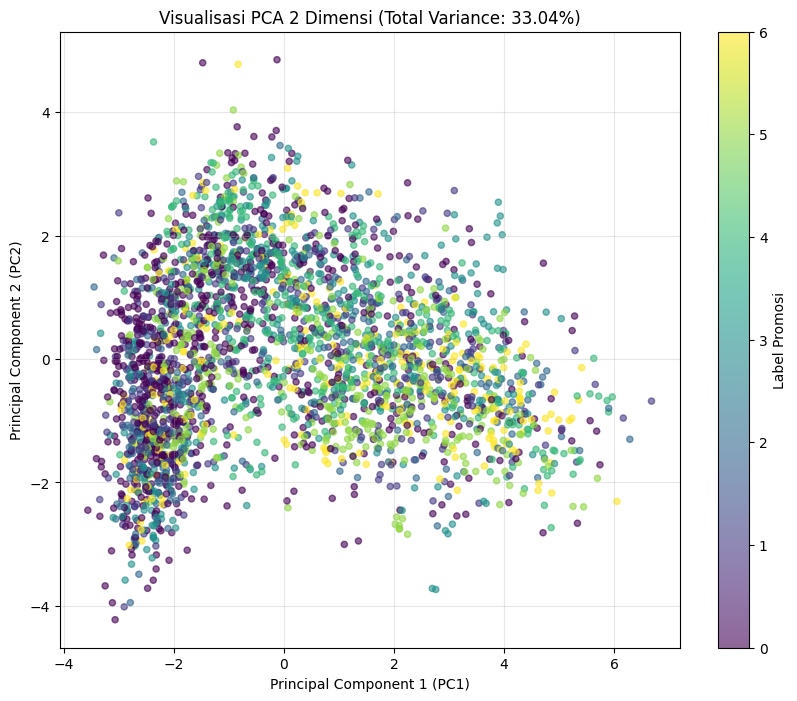

In [18]:
# VISUALISASI 2D (Untuk Analisis Laporan)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_final['PC1'], X_train_final['PC2'], 
                      c=y_train, cmap='viridis', alpha=0.6, s=20)
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title(f'Visualisasi PCA 2 Dimensi (Total Variance: {total_variance:.2f}%)')
plt.colorbar(scatter, label='Label Promosi')
plt.grid(True, alpha=0.3)
plt.show()

## **MANUAL CALCULATION**

In [19]:
train_sample = X_train_final.iloc[:5]
val_sample = X_val_final.iloc[:1]

In [20]:
X_train_final.to_csv('../dataset/X_train_skenario1_DR.csv', index=False)
X_val_final.to_csv('../dataset/X_val_skenario1_DR.csv', index=False)

In [21]:
dists = []
for i in range(len(train_sample)):
    # Euclidean Distance
    d = np.linalg.norm(train_sample.iloc[i] - val_sample.iloc[0])
    dists.append(d)

In [22]:
# untuk k=3
manual_res = pd.DataFrame({
    'Train_Idx': train_sample.index, 
    'Dist': dists, 
    'Label': y_train.iloc[:5].values
}).sort_values('Dist')
manual_res.head(3)

,Train_Idx,Dist,Label
0,0,0.591090,4
3,3,2.593059,0
4,4,2.810595,4


## **MODELING**


Mencari nilai K terbaik...
Best K: 17, Best Metric: euclidean, Best Weights: distance dengan akurasi: 0.2997


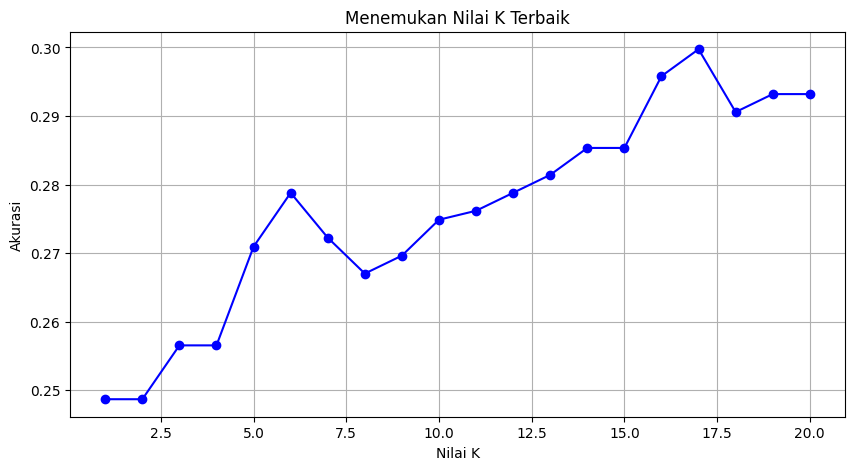

In [23]:
# Menentukan Best parameter K
best_acc = 0
best_k = 1
accuracies = []

print("\nMencari nilai K terbaik...")
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')
    knn.fit(X_train_final, y_train)

    y_pred = knn.predict(X_val_final)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)
    
    if acc > best_acc:
        best_acc = acc
        best_k = k
        best_metric = knn.metric
        best_weights = knn.weights
    


print(f"Best K: {best_k}, Best Metric: {best_metric}, Best Weights: {best_weights} dengan akurasi: {best_acc:.4f}")

# Visualisasi K
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), accuracies, marker='o', linestyle='-', color='b')
plt.title('Menemukan Nilai K Terbaik')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi')
plt.grid(True)
plt.show()

In [24]:
# Training
knn_final = KNeighborsClassifier(n_neighbors=best_k, weights=best_weights, metric=best_metric)
knn_final.fit(X_train_final, y_train)
y_pred = knn_final.predict(X_val_final)

## **EVALUATION**

              precision    recall  f1-score   support

           0       0.36      0.43      0.39       195
           1       0.19      0.11      0.14       120
           2       0.18      0.10      0.13        79
           3       0.28      0.20      0.23        84
           4       0.28      0.54      0.37        91
           5       0.36      0.40      0.38       120
           6       0.21      0.15      0.17        75

    accuracy                           0.30       764
   macro avg       0.27      0.27      0.26       764
weighted avg       0.28      0.30      0.28       764



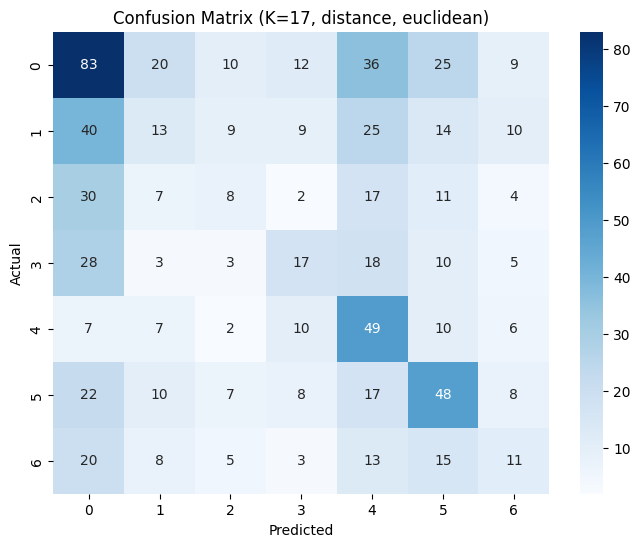

In [25]:
print(classification_report(y_val, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (K={best_k}, {knn_final.weights}, {knn_final.metric})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## **HYPERPARAMETER TUNNING**

In [26]:
print("\n" + "="*40)
print("MEMULAI PENCARIAN PARAMETER TERBAIK...")
print("="*40)

best_score = 0
best_k = 0
best_weight = ''
best_metric = ''

# K dari 1 sampai 30
# weight: uniform (sama rata) dan distance (yang dekat lebih berpengaruh)
# metric: euclidean, manhattan, minkowski
for k in range(1, 31):
    for weight in ['uniform', 'distance']:
        for metric in ['euclidean', 'manhattan', 'minkowski']:
            knn_tuning = KNeighborsClassifier(n_neighbors=k, weights=weight, metric=metric)
            knn_tuning.fit(X_train_final, y_train)
            score = knn_tuning.score(X_val_final, y_val)
            
            if score > best_score:
                best_score = score
                best_k = k
                best_weight = weight
                best_metric = metric

print(f"Parameter Terbaik Ditemukan:")
print(f"  - K (Jumlah Tetangga): {best_k}")
print(f"  - Weights (Bobot): {best_weight}")
print(f"  - Metric (Jarak): {best_metric}")
print(f"  - Akurasi Tertinggi: {best_score:.4f}")


MEMULAI PENCARIAN PARAMETER TERBAIK...
Parameter Terbaik Ditemukan:
  - K (Jumlah Tetangga): 17
  - Weights (Bobot): distance
  - Metric (Jarak): euclidean
  - Akurasi Tertinggi: 0.2997



Classification Report (Model Optimal):
              precision    recall  f1-score   support

           0       0.36      0.43      0.39       195
           1       0.19      0.11      0.14       120
           2       0.18      0.10      0.13        79
           3       0.28      0.20      0.23        84
           4       0.28      0.54      0.37        91
           5       0.36      0.40      0.38       120
           6       0.21      0.15      0.17        75

    accuracy                           0.30       764
   macro avg       0.27      0.27      0.26       764
weighted avg       0.28      0.30      0.28       764



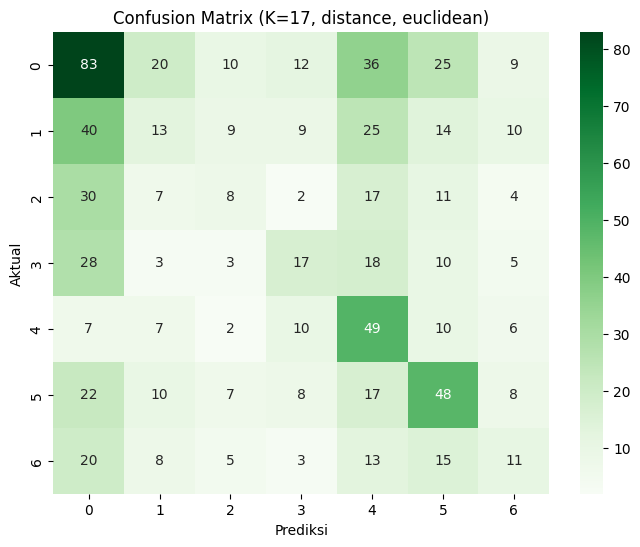

In [27]:
# evaluasi model dengan parameter terbaik
final_model = KNeighborsClassifier(n_neighbors=best_k, weights=best_weight, metric=best_metric)
final_model.fit(X_train_final, y_train)
final_pred = final_model.predict(X_val_final)

print("\nClassification Report (Model Optimal):")
print(classification_report(y_val, final_pred))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_val, final_pred), annot=True, fmt='d', cmap='Greens')
plt.title(f'Confusion Matrix (K={best_k}, {best_weight}, {best_metric})')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()